In [1]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
blockSize = 32

In [3]:
def sanitize_string(s):
    # remove every non-alpha character
    sanitized = ''.join(c for c in s.lower() if c.isalpha())
    return sanitized.lower()

In [4]:
def toWindows(s, blockSize=blockSize):
    i = 0
    out = []
    while i < len(s)-blockSize:
        block = s[i:i+blockSize]
        i += 1
        out.append(block)
    return out


In [ ]:
def str_to_neurons(s):
    # convert string to list of neurons
    usage_data = {}
    for c in s:
        if c not in usage_data:
            usage_data[c] = 0
        usage_data[c]+=1
    for c in usage_data:
        usage_data[c] = usage_data[c] / len(s)
    neurons = np.zeros(ord('z') - ord('a') + 1)
    for c in range(ord('a'), ord('z') + 1):
        if chr(c) in usage_data:
            neurons[c - ord('a')] = usage_data[chr(c)]
    return neurons


In [6]:
s = None
with open("zlaczone.txt", "r") as f:
    s = toWindows(sanitize_string(f.read()), blockSize)

In [7]:
r = None
with open("random.txt", "r") as f:
    r = toWindows(sanitize_string(f.read()), blockSize)
r = r[:len(s)]

In [8]:
r = [(i, 0) for i in r]
s = [(i, 1) for i in s]
df = pd.DataFrame(r + s, columns=["text", "label"])

In [9]:
df

,text,label
0,avsjutvuacikszktixeydrvzvwtsincy,0
1,vsjutvuacikszktixeydrvzvwtsincyn,0
2,sjutvuacikszktixeydrvzvwtsincynx,0
3,jutvuacikszktixeydrvzvwtsincynxc,0
4,utvuacikszktixeydrvzvwtsincynxcc,0
...,...,...
15351,ljsasjfdkfljwsajksjfjaskjfkasjkf,1
15352,jsasjfdkfljwsajksjfjaskjfkasjkfj,1
15353,sasjfdkfljwsajksjfjaskjfkasjkfjs,1
15354,asjfdkfljwsajksjfjaskjfkasjkfjsf,1


In [10]:
data = np.array(df["text"].apply(str_to_neurons).tolist())
labels = df["label"].values

In [11]:
data

array([[0.0625 , 0.     , 0.0625 , ..., 0.03125, 0.0625 , 0.0625 ],
       [0.03125, 0.     , 0.0625 , ..., 0.03125, 0.0625 , 0.0625 ],
       [0.03125, 0.     , 0.0625 , ..., 0.0625 , 0.0625 , 0.0625 ],
       ...,
       [0.125  , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.125  , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.125  , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]],
      shape=(15356, 26))

In [12]:
X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

In [13]:
# Split into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN(X.shape[1])

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training loop
epochs = 200
batch_size = 32
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Accuracy
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).argmax(dim=1)
        train_acc = (train_pred == y_train).float().mean().item()
        val_pred = model(X_val).argmax(dim=1)
        val_acc = (val_pred == y_val).float().mean().item()
        train_accs.append(train_acc)
        val_accs.append(val_acc)



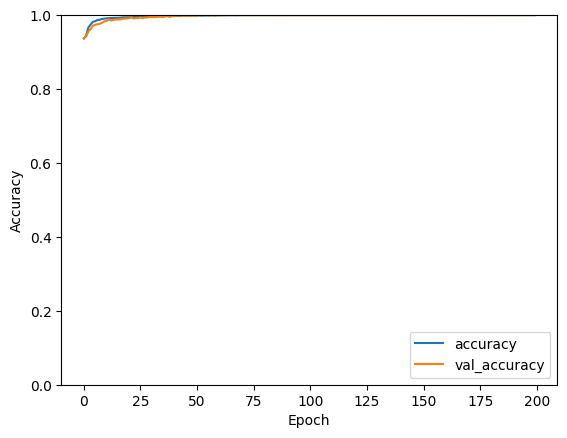

1.0 1.0


In [16]:
# Plot accuracy
plt.figure()
plt.plot(train_accs, label='accuracy')
plt.plot(val_accs, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
print(train_accs[-1], val_accs[-1])


In [40]:
test_str = "vxwpleiilbhoyrxqfeicuhvikyqadjbl"
test_arr = np.array([str_to_neurons(sanitize_string(test_str)[:blockSize])])
print(test_arr)
test_tensor = torch.tensor(test_arr, dtype=torch.float32)
model.eval()
with torch.no_grad():
    pred = model(test_tensor)
    dane = torch.softmax(pred, dim=1)[0, :]
    print(f"Random {round(float(dane[0]), 6)}")
    print(f"Human {round(float(dane[1]), 6)}")

[[0.03125 0.0625  0.03125 0.03125 0.0625  0.03125 0.      0.0625  0.125
  0.03125 0.03125 0.09375 0.      0.      0.03125 0.03125 0.0625  0.03125
  0.      0.      0.03125 0.0625  0.03125 0.0625  0.0625  0.     ]]
Random 1.0
Human 0.0


In [37]:
from generate import generate_random
test_str = generate_random(blockSize)
print(test_str)
test_arr = np.array([str_to_neurons(sanitize_string(test_str))])
test_tensor = torch.tensor(test_arr, dtype=torch.float32)
model.eval()
with torch.no_grad():
    pred = model(test_tensor)
    dane = torch.softmax(pred, dim=1)[0, :]
    print(f"Random {round(float(dane[0]), 6)}")
    print(f"Human {round(float(dane[1]), 6)}")


vxwpleiilahoyrxqfeicuhvikyqadjbl
Random 1.0
Human 0.0
